## Libraries

In [ ]:
!pip install openai-clip datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.5 MB/s eta 0:00:00
  Created wheel for openai-clip: filename=openai_clip-1.0.1-py3-none-any.whl size=1368605 sha256=a58f5fed56d4425050c6f091eeb2ceda00b65ae615de6e340ea1e625ed8f4077
  Stored in directory: /root/.cache/pip/wheels/08/77/8e/8d2f862df6bf7fb4e2007062d2cbaeae49862ec7b56d041229
Successfully built openai-clip


In [ ]:
import clip
from torch import nn
import numpy as np
import torch
import torch.nn.functional as nnf
import sys
from typing import Tuple, List, Union, Optional
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
from google.colab import files
import skimage.io as io
import requests

import json
import string, os, re, pickle
import pandas as pd
from PIL import Image
from io import StringIO
from datasets import Dataset

from torch.utils.data import DataLoader
from transformers import CLIPProcessor, CLIPModel, CLIPVisionConfig

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load testing dataset

In [ ]:
image_path = "/content/drive/MyDrive/datasets/pokemon_png"
caption_path = "/content/drive/MyDrive/datasets/pokemon_caption.csv"

In [ ]:
#read caption file
caption_df = pd.read_csv(caption_path)

#tidy up columns
caption_df.drop(caption_df.columns[[0,1,3]],axis=1,inplace=True)
caption_df.columns = ['pokedex','image','caption_1','caption_2']

#remove tag, carriage return, punctuation, leading/trailing space from caption
caption_df["caption_1"] = caption_df["caption_1"].str.replace('<p class="version-x active">\n', "")
caption_df["caption_1"] = caption_df["caption_1"].str.replace('\n                </p>', "")
caption_df["caption_2"] = caption_df["caption_2"].str.replace('<p class="version-y">\n', "")
caption_df["caption_2"] = caption_df["caption_2"].str.replace('\n                </p>', "")

caption_df["caption_1"] = caption_df["caption_1"].str.translate(str.maketrans('', '', string.punctuation))
caption_df["caption_2"] = caption_df["caption_2"].str.translate(str.maketrans('', '', string.punctuation))

caption_df["caption_1"] = caption_df["caption_1"].str.strip()
caption_df["caption_2"] = caption_df["caption_2"].str.strip()

#add filename column
#caption_df['image'] = caption_df["image"].transform(lambda x: image_path + "/" + x[x.rindex('/')+1:].strip("0"))

#concatenate caption 1 and 2
df1 = caption_df[['image','caption_1']].rename(columns={'caption_1': 'text'})
df2 = caption_df[['image','caption_2']].rename(columns={'caption_2': 'text'})
dataset_df = pd.concat([df1,df2], ignore_index=True)

#drop caption rows with no image
dataset_df.reset_index(drop=True, inplace=True)

#check
display(dataset_df)

,image,text
0,https://assets.pokemon.com/assets/cms2/img/pok...,For some time after its birth it uses the nutr...
1,https://assets.pokemon.com/assets/cms2/img/pok...,The more sunlight Ivysaur bathes in the more s...
2,https://assets.pokemon.com/assets/cms2/img/pok...,While it basks in the sun it can convert the l...
3,https://assets.pokemon.com/assets/cms2/img/pok...,The flame on its tail shows the strength of it...
4,https://assets.pokemon.com/assets/cms2/img/pok...,When it swings its burning tail the temperatur...
...,...,...
2045,https://assets.pokemon.com/assets/cms2/img/pok...,It bears resemblance to a Pokémon that became ...
2046,https://assets.pokemon.com/assets/cms2/img/pok...,It was named after a mysterious object recorde...
2047,https://assets.pokemon.com/assets/cms2/img/pok...,There was supposedly an incident in which it l...
2048,https://assets.pokemon.com/assets/cms2/img/pok...,It’s thought that this Pokémon lived in ancien...


In [ ]:
def gen():
    for index, row in dataset_df.iterrows():
      yield {"text":row["text"], "image":Image.open(requests.get(row['image'], stream=True).raw)}
dataset = Dataset.from_generator(gen).shuffle(seed=123)
dataset = dataset.train_test_split(test_size=0.1, shuffle = False)

Generating train split: 0 examples [00:00, ? examples/s]

## Functions for text generation

In [ ]:
class MLP(nn.Module):
    def forward(self, x):
        return self.model(x)

    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) -1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)


class ClipCaptionModel(nn.Module):
    #@functools.lru_cache #FIXME
    def get_dummy_token(self, batch_size, device):
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    def forward(self, tokens, prefix, mask = None, labels = None):
        embedding_text = self.gpt.transformer.wte(tokens)
        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.gpt_embedding_size)
        #print(embedding_text.size()) #torch.Size([5, 67, 768])
        #print(prefix_projections.size()) #torch.Size([5, 1, 768])
        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out

    def __init__(self, prefix_length, prefix_size = 512):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length
        self.gpt = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        self.clip_project = MLP((prefix_size, (self.gpt_embedding_size * prefix_length) // 2, self.gpt_embedding_size * prefix_length))

def generate2(
        model,
        tokenizer,
        tokens=None,
        prompt=None,
        embed=None,
        entry_count=1,
        entry_length=67,  # maximum number of words
        top_p=0.8,
        temperature=1.,
        stop_token: str = '.',
):
    model.eval()
    generated_num = 0
    generated_list = []
    stop_token_index = tokenizer.encode(stop_token)[0]
    filter_value = -float("Inf")
    device = next(model.parameters()).device

    with torch.no_grad():

        for entry_idx in trange(entry_count):
            if embed is not None:
                generated = embed
            else:
                if tokens is None:
                    tokens = torch.tensor(tokenizer.encode(prompt))
                    tokens = tokens.unsqueeze(0).to(device)

                generated = model.gpt.transformer.wte(tokens)

            for i in range(entry_length):

                outputs = model.gpt(inputs_embeds=generated)
                logits = outputs.logits
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(nnf.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                                                    ..., :-1
                                                    ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value
                next_token = torch.argmax(logits, -1).unsqueeze(0)
                next_token_embed = model.gpt.transformer.wte(next_token)
                if tokens is None:
                    tokens = next_token
                else:
                    tokens = torch.cat((tokens, next_token), dim=1)
                generated = torch.cat((generated, next_token_embed), dim=1)
                if stop_token_index == next_token.item():
                    break

            output_list = list(tokens.squeeze().cpu().numpy())
            output_text = tokenizer.decode(output_list)
            generated_list.append(output_text)

    return generated_list[0]

 ## Load fine-tuned model and predict

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
prefix_length = 10

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
prefix_length = 10

model = ClipCaptionModel(prefix_length)

os.system("gdown https://drive.google.com/uc?id=14pXWwB4Zm82rsDdvbGguLfx9F8aM7ovT")
altered_state_dict = torch.load('conceptual_weights.pt', map_location=torch.device('cpu'))
for i in range(12):
    del altered_state_dict['gpt.transformer.h.' + str(i) + '.attn.bias']
    del altered_state_dict['gpt.transformer.h.' + str(i) + '.attn.masked_bias']
model.load_state_dict(altered_state_dict)

model = model.eval()
model = model.to(device)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
clip_model_trained, preprocess_trained = clip.load("ViT-B/32", device=device, jit=False)

checkpoint = torch.load(f"/content/drive/MyDrive/Pretrained Models/clip_hard_9.pt")
clip_model_trained.load_state_dict(checkpoint['model_state_dict'])

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 197MiB/s]


<All keys matched successfully>

In [ ]:
generated_captions = []
prefix_traineds = []
print(len(dataset["test"]))

# prepare image for the model
for i, example in enumerate(dataset["test"]):
  print(i)
  pil_image = example["image"]
  image_trained = preprocess_trained(pil_image).unsqueeze(0).to(device)
  with torch.no_grad():
      prefix_trained = clip_model_trained.encode_image(image_trained).to(device, dtype=torch.float32)
      prefix_traineds.append(prefix_trained)
      prefix_embed = model.clip_project(prefix_trained).reshape(1, prefix_length, -1)

  generated_caption = generate2(model, tokenizer, embed=prefix_embed)
  print(generated_caption)
  generated_captions.append(generated_caption)

205
0


100%|██████████| 1/1 [00:04<00:00,  4.85s/it]


the wings of a red pheasant.
1


100%|██████████| 1/1 [00:00<00:00, 10.26it/s]


the monster in the middle.
2


100%|██████████| 1/1 [00:00<00:00,  7.61it/s]


a cup of tea with a butterfly.
3


100%|██████████| 1/1 [00:00<00:00,  5.69it/s]


the dragonflies are a symbol of peace and love.
4


100%|██████████| 1/1 [00:00<00:00,  8.77it/s]


the symbol of the year.
5


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


i'm not sure what this is, but it's a cute little owl.
6


100%|██████████| 1/1 [00:00<00:00,  9.22it/s]


person is a beautiful bird.
7


100%|██████████| 1/1 [00:00<00:00,  5.86it/s]


the world's most popular halloween costumes.
8


100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


the foxes are the most popular animal in the world.
9


100%|██████████| 1/1 [00:00<00:00,  5.49it/s]


person is a gecko that was created by person.
10


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


i'm not sure what this is, but it's a pretty flower.
11


100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


person is a sculptor and illustrator based.
12


100%|██████████| 1/1 [00:00<00:00,  9.14it/s]


a butterfly on a leaf.
13


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


i'm not sure what this is, but it's a wolf in a gas mask.
14


100%|██████████| 1/1 [00:00<00:00, 10.17it/s]


a dragonfly in a glass.
15


100%|██████████| 1/1 [00:00<00:00, 10.98it/s]


the most beautiful animals in the world.
16


100%|██████████| 1/1 [00:00<00:00, 14.68it/s]


a cat with a heart.
17


100%|██████████| 1/1 [00:00<00:00,  7.39it/s]


the foxes are the most beautiful animals in the world.
18


100%|██████████| 1/1 [00:00<00:00, 12.64it/s]


fire and flames of the logo.
19


100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


i'm not sure what kind of bird this is, but i love the look of it.
20


100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


biological species is a bird of prey.
21


100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


the dragon of the night.
22


100%|██████████| 1/1 [00:00<00:00,  8.06it/s]


the bird of prey is a bird of prey.
23


100%|██████████| 1/1 [00:00<00:00, 12.80it/s]


digital art selected for the #.
24


100%|██████████| 1/1 [00:00<00:00, 12.18it/s]


digital art selected for the #.
25


100%|██████████| 1/1 [00:00<00:00, 10.78it/s]


cat in the shape of a heart.
26


100%|██████████| 1/1 [00:00<00:00, 14.24it/s]


the spirit of the spirit.
27


100%|██████████| 1/1 [00:00<00:00,  8.95it/s]


the sun is the star of our planet.
28


100%|██████████| 1/1 [00:00<00:00,  9.18it/s]


person is a talented illustrator and designer.
29


100%|██████████| 1/1 [00:00<00:00, 11.24it/s]


the most beautiful animals in the world.
30


100%|██████████| 1/1 [00:00<00:00,  8.70it/s]


the logo is a symbol of strength and pride.
31


100%|██████████| 1/1 [00:00<00:00,  7.43it/s]


the foxes are the most beautiful animals in the world.
32


100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


the cat in the yellow circle.
33


100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


digital art selected for the #.
34


100%|██████████| 1/1 [00:00<00:00, 14.66it/s]


a butterfly in the sky.
35


100%|██████████| 1/1 [00:00<00:00, 14.08it/s]


the light of the world.
36


100%|██████████| 1/1 [00:00<00:00, 12.71it/s]


a cat with a butterfly tattoo.
37


100%|██████████| 1/1 [00:00<00:00, 13.40it/s]


a cat with a bone.
38


100%|██████████| 1/1 [00:00<00:00, 10.95it/s]


the antlers of a deer.
39


100%|██████████| 1/1 [00:00<00:00, 12.00it/s]


digital art selected for the #.
40


100%|██████████| 1/1 [00:00<00:00,  9.32it/s]


the leopard is a symbol of peace.
41


100%|██████████| 1/1 [00:00<00:00,  7.75it/s]


a blue and white cat with a heart shaped shadow.
42


100%|██████████| 1/1 [00:00<00:00, 14.88it/s]


the wings of the angels.
43


100%|██████████| 1/1 [00:00<00:00, 14.21it/s]


the art of the dragon.
44


100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


the wings of the dragon.
45


100%|██████████| 1/1 [00:00<00:00, 12.66it/s]


the world is in your hands.
46


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


i'm not sure what this is, but it's a cute idea for a tattoo.
47


100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


digital art selected for the #.
48


100%|██████████| 1/1 [00:00<00:00,  8.32it/s]


the logo is a symbol of the new year.
49


100%|██████████| 1/1 [00:00<00:00,  9.34it/s]


the sun is the star of the universe.
50


100%|██████████| 1/1 [00:00<00:00, 13.81it/s]


the dragon in the forest.
51


100%|██████████| 1/1 [00:00<00:00,  6.99it/s]


a purple dragon tattooed on a man's back.
52


100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


digital art selected for the #.
53


100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


digital art selected for the #.
54


100%|██████████| 1/1 [00:00<00:00, 10.53it/s]


digital art selected for the #.
55


100%|██████████| 1/1 [00:00<00:00,  8.24it/s]


this is a shark that looks like a human.
56


100%|██████████| 1/1 [00:00<00:00, 10.82it/s]


the most beautiful cat in the world.
57


100%|██████████| 1/1 [00:00<00:00, 12.36it/s]


the purple dragonfly by person.
58


100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


the world's most recently posted photos of scary and funny animals, written with their faces - so you can see why they are there.
59


100%|██████████| 1/1 [00:00<00:00,  8.49it/s]


the logo is a symbol of the zebra.
60


100%|██████████| 1/1 [00:00<00:00, 10.39it/s]


the most interesting cat in the meme.
61


100%|██████████| 1/1 [00:00<00:00,  8.50it/s]


pink and black owl on a pink background.
62


100%|██████████| 1/1 [00:00<00:00, 12.61it/s]


the new logo for the team.
63


100%|██████████| 1/1 [00:00<00:00, 14.23it/s]


the wings of a bird.
64


100%|██████████| 1/1 [00:00<00:00, 15.06it/s]


the wings of the eagle.
65


100%|██████████| 1/1 [00:00<00:00,  6.05it/s]


pink piggy bank - i want this for my birthday!.
66


100%|██████████| 1/1 [00:00<00:00, 14.11it/s]


the wings of the dragon.
67


100%|██████████| 1/1 [00:00<00:00,  7.18it/s]


the leopard is the symbol of the new year.
68


100%|██████████| 1/1 [00:00<00:00, 13.56it/s]


the wings of the angel.
69


100%|██████████| 1/1 [00:00<00:00,  7.43it/s]


the sun symbolizes the spirit of the spirit.
70


100%|██████████| 1/1 [00:00<00:00, 13.67it/s]


a butterfly in the sky.
71


100%|██████████| 1/1 [00:00<00:00,  8.98it/s]


owl with a flower in its beak.
72


100%|██████████| 1/1 [00:00<00:00, 10.33it/s]


this is a picture of a lizard.
73


100%|██████████| 1/1 [00:00<00:00, 10.87it/s]


a bird with a yellow beak.
74


100%|██████████| 1/1 [00:00<00:00, 10.55it/s]


the most interesting cat in the meme.
75


100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


digital art selected for the #.
76


100%|██████████| 1/1 [00:00<00:00,  7.08it/s]


the world's most detailed illustration of a flying robot.
77


100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


the wings of a dragonfly.
78


100%|██████████| 1/1 [00:00<00:00,  8.46it/s]


the butterfly is a symbol of the new year.
79


100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


the green frog with pink eyes.
80


100%|██████████| 1/1 [00:00<00:00, 12.04it/s]


the purple dragonfly by person.
81


100%|██████████| 1/1 [00:00<00:00, 12.66it/s]


digital art selected for the #.
82


100%|██████████| 1/1 [00:00<00:00, 13.60it/s]


a flower for every day.
83


100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


i'm not sure what this is, but it's a cute idea for a logo.
84


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


i'm not sure what this is, but it's a cute idea.
85


100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


the sun is the star of the cartoon.
86


100%|██████████| 1/1 [00:00<00:00,  7.44it/s]


the moon in a round - up of ideas.
87


100%|██████████| 1/1 [00:00<00:00,  7.05it/s]


the logo is a symbol of hope.
88


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


the dragon is a symbol of the zodiac sign.
89


100%|██████████| 1/1 [00:00<00:00,  7.43it/s]


the art of person, by person.
90


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


person is a cross between a zebra and a zebra.
91


100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


digital art selected for the #.
92


100%|██████████| 1/1 [00:00<00:00,  7.00it/s]


the logo is a symbol of the spirit.
93


100%|██████████| 1/1 [00:00<00:00,  8.54it/s]


the rabbit in the egg.
94


100%|██████████| 1/1 [00:00<00:00,  6.03it/s]


the logo is a symbol of the brand.
95


100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


the power of the pink.
96


100%|██████████| 1/1 [00:00<00:00,  6.27it/s]


the dragon's head in the sky.
97


100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


person is a great idea for a kid's room.
98


100%|██████████| 1/1 [00:00<00:00,  9.96it/s]


a butterfly on a flower.
99


100%|██████████| 1/1 [00:00<00:00,  5.97it/s]


the logo is a symbol of strength and strength.
100


100%|██████████| 1/1 [00:00<00:00, 10.26it/s]


the spirit of the moon.
101


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


the blue and white penguin is a symbol of hope.
102


100%|██████████| 1/1 [00:00<00:00,  9.04it/s]


a dragon in the jungle.
103


100%|██████████| 1/1 [00:00<00:00,  8.60it/s]


the wings of a butterfly.
104


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


this is a cute cartoon that i made for my daughter.
105


100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


this is the most photogenic dinosaur in the world.
106


100%|██████████| 1/1 [00:00<00:00, 11.03it/s]


the most interesting gorilla in the meme.
107


100%|██████████| 1/1 [00:00<00:00, 12.08it/s]


the face of a monster.
108


100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


a bird with wings like a bird.
109


100%|██████████| 1/1 [00:00<00:00, 12.39it/s]


the purple dragonfly by person.
110


100%|██████████| 1/1 [00:00<00:00, 13.39it/s]


the wings of a butterfly.
111


100%|██████████| 1/1 [00:00<00:00,  9.53it/s]


the logo is a symbol of the sea.
112


100%|██████████| 1/1 [00:00<00:00, 12.04it/s]


digital art selected for the #.
113


100%|██████████| 1/1 [00:00<00:00,  7.23it/s]


i'm going to make a cat out of this.
114


100%|██████████| 1/1 [00:00<00:00,  9.61it/s]


the most interesting cat in the meme.
115


100%|██████████| 1/1 [00:00<00:00, 12.11it/s]


a flower for every day.
116


100%|██████████| 1/1 [00:00<00:00, 14.56it/s]


a tree with a heart.
117


100%|██████████| 1/1 [00:00<00:00, 10.15it/s]


the most interesting animals in the world.
118


100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


digital art selected for the #.
119


100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


a beautiful illustration of a crab.
120


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


i'm not sure what this is, but it's a cute idea for a flower.
121


100%|██████████| 1/1 [00:00<00:00, 10.84it/s]


the dragon is a symbol of love.
122


100%|██████████| 1/1 [00:00<00:00,  9.06it/s]


the butterfly is a symbol of the spirit.
123


100%|██████████| 1/1 [00:00<00:00, 12.61it/s]


a bird in a nest.
124


100%|██████████| 1/1 [00:00<00:00, 11.82it/s]


digital art selected for the #.
125


100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


the tree of life by person.
126


100%|██████████| 1/1 [00:00<00:00,  9.09it/s]


the sun is the star of the sky.
127


100%|██████████| 1/1 [00:00<00:00, 12.28it/s]


digital art selected for the #.
128


100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


the art of the golden ratio.
129


100%|██████████| 1/1 [00:00<00:00,  9.26it/s]


the blue whale is a symbol of hope.
130


100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


the logo is a symbol of the spirit.
131


100%|██████████| 1/1 [00:00<00:00,  8.03it/s]


the dragon's head in the sky.
132


100%|██████████| 1/1 [00:00<00:00, 14.27it/s]


the frog in the garden.
133


100%|██████████| 1/1 [00:00<00:00,  9.06it/s]


person is a talented artist and illustrator.
134


100%|██████████| 1/1 [00:00<00:00, 12.92it/s]


a turtle in the moon.
135


100%|██████████| 1/1 [00:00<00:00, 10.88it/s]


person is a fan of the sport.
136


100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


a dragonfly in a glass.
137


100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


the wings of a dragonfly.
138


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


i'm not sure what this is, but it's a cute little thing.
139


100%|██████████| 1/1 [00:00<00:00,  8.42it/s]


the purple cat is a symbol of love.
140


100%|██████████| 1/1 [00:00<00:00,  8.68it/s]


the sun is the star of the constellation.
141


100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


the purple cat in the purple.
142


100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


the world's most recently posted photos of police and car and brochure - hive mind.
143


100%|██████████| 1/1 [00:00<00:00,  6.94it/s]


person is a cat who loves to play with the flowers.
144


100%|██████████| 1/1 [00:00<00:00,  8.75it/s]


the most interesting penguin in the world.
145


100%|██████████| 1/1 [00:00<00:00,  7.58it/s]


the logo is a symbol of strength and strength.
146


100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


the sun is the star of the sky.
147


100%|██████████| 1/1 [00:00<00:00,  6.02it/s]


the world's most recently posted photos of police and fictional object.
148


100%|██████████| 1/1 [00:00<00:00,  8.12it/s]


the most unusual and interesting alien in the universe.
149


100%|██████████| 1/1 [00:00<00:00,  8.99it/s]


a cat in the shape of a heart.
150


100%|██████████| 1/1 [00:00<00:00,  8.23it/s]


the sunflower is a symbol of the soul.
151


100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


the wings of a dragonfly.
152


100%|██████████| 1/1 [00:00<00:00,  6.03it/s]


pink and person is a fun pink and white themed car.
153


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


the most interesting cat in the meme.
154


100%|██████████| 1/1 [00:00<00:00, 11.91it/s]


person in the sky by person.
155


100%|██████████| 1/1 [00:00<00:00,  8.28it/s]


the sun is the center of our solar system.
156


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


the most interesting cat in the meme.
157


100%|██████████| 1/1 [00:00<00:00, 13.71it/s]


the rabbit in the nest.
158


100%|██████████| 1/1 [00:00<00:00,  8.97it/s]


a fox in the shape of a heart.
159


100%|██████████| 1/1 [00:00<00:00,  9.41it/s]


the sun is the star of the universe.
160


100%|██████████| 1/1 [00:00<00:00, 13.69it/s]


the wings of the eagle.
161


100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


the sun is the star of the sky.
162


100%|██████████| 1/1 [00:00<00:00,  7.59it/s]


the blue dragon is a symbol of strength and pride.
163


100%|██████████| 1/1 [00:00<00:00, 12.77it/s]


the moon in the grass.
164


100%|██████████| 1/1 [00:00<00:00,  9.62it/s]


the logo is a symbol of the spirit.
165


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


i'm not sure what this is, but it's a cute idea for a tattoo.
166


100%|██████████| 1/1 [00:00<00:00, 10.71it/s]


the art of person, by person.
167


100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


i'm not a fan of cats, but this is cute.
168


100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


person is a fan of the series.
169


100%|██████████| 1/1 [00:00<00:00,  9.46it/s]


the logo is a symbol of the spirit.
170


100%|██████████| 1/1 [00:00<00:00, 12.57it/s]


a little angel in the sky.
171


100%|██████████| 1/1 [00:00<00:00, 10.33it/s]


the most interesting animal in the world.
172


100%|██████████| 1/1 [00:00<00:00, 10.66it/s]


a pair of wings in the sky.
173


100%|██████████| 1/1 [00:00<00:00,  8.32it/s]


person is a talented illustrator and animator.
174


100%|██████████| 1/1 [00:00<00:00,  8.86it/s]


the most interesting cat in the world.
175


100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


a butterfly on a leaf.
176


100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


digital art selected for the #.
177


100%|██████████| 1/1 [00:00<00:00,  8.84it/s]


the logo is a symbol of the future.
178


100%|██████████| 1/1 [00:00<00:00,  8.43it/s]


a butterfly in a glass jar.
179


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


the wolf is the most dangerous animal in the world.
180


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


i'm not sure what this is, but it's a cute idea for a tattoo.
181


100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


the wings of a white butterfly.
182


100%|██████████| 1/1 [00:00<00:00, 10.29it/s]


cat in the purple dress.
183


100%|██████████| 1/1 [00:00<00:00,  5.42it/s]


i'm going to have a snake in my house.
184


100%|██████████| 1/1 [00:00<00:00,  7.33it/s]


cat in the purple purple purple.
185


100%|██████████| 1/1 [00:00<00:00,  6.41it/s]


person is a marine biologist and illustrator.
186


100%|██████████| 1/1 [00:00<00:00,  9.16it/s]


a bird in the sky.
187


100%|██████████| 1/1 [00:00<00:00,  7.38it/s]


the most beautiful cats in the world.
188


100%|██████████| 1/1 [00:00<00:00,  7.65it/s]


the most interesting animals in the world.
189


100%|██████████| 1/1 [00:00<00:00, 10.08it/s]


the symbol of the sun.
190


100%|██████████| 1/1 [00:00<00:00,  5.72it/s]


the dragon is the symbol of the new year.
191


100%|██████████| 1/1 [00:00<00:00,  9.17it/s]


digital art selected for the #.
192


100%|██████████| 1/1 [00:00<00:00, 10.39it/s]


a butterfly in the garden.
193


100%|██████████| 1/1 [00:00<00:00,  7.09it/s]


a cat with a missing tooth.
194


100%|██████████| 1/1 [00:00<00:00,  7.80it/s]


deer in the night by person.
195


100%|██████████| 1/1 [00:00<00:00,  6.59it/s]


the most beautiful animals in the world.
196


100%|██████████| 1/1 [00:00<00:00,  6.80it/s]


digital art selected for the #.
197


100%|██████████| 1/1 [00:00<00:00,  7.42it/s]


a cat with a yellow heart.
198


100%|██████████| 1/1 [00:00<00:00,  7.27it/s]


the giraffe is the symbol of love.
199


100%|██████████| 1/1 [00:00<00:00,  9.16it/s]


the most beautiful birds in the world.
200


100%|██████████| 1/1 [00:00<00:00, 12.91it/s]


the birds of the sky.
201


100%|██████████| 1/1 [00:00<00:00,  9.09it/s]


the sun is the star of the show.
202


100%|██████████| 1/1 [00:00<00:00,  7.31it/s]


the red dragon is the symbol of the new year.
203


100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


digital art selected for the #.
204


100%|██████████| 1/1 [00:00<00:00, 11.56it/s]

digital art selected for the #.


In [ ]:
save_array = []
for i, example in enumerate(dataset["test"]):
  save_array.append([example["text"], generated_captions[i]])
save_array

dataframe = pd.DataFrame(save_array)
dataframe.to_csv("/content/drive/MyDrive/result/clip_hard_10.csv")

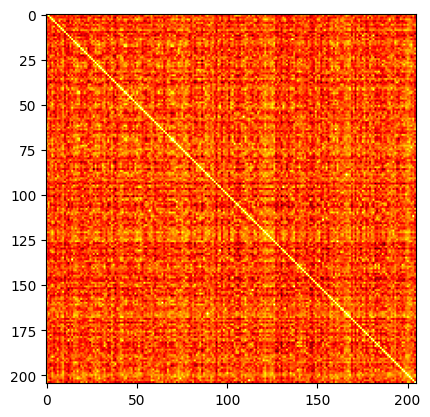

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

arrays = []
for i in prefix_traineds:
  arrays.append(i.cpu().data.numpy()[0])

heatmapdata = cosine_similarity(arrays)

plt.imshow(heatmapdata, cmap='hot')
plt.show()

In [ ]:
heatmapdata

array([[1.0000004 , 0.7250353 , 0.68965167, ..., 0.8184827 , 0.7576386 ,
        0.8152828 ],
       [0.7250353 , 0.9999994 , 0.6757806 , ..., 0.74474525, 0.8463836 ,
        0.67384994],
       [0.68965167, 0.6757806 , 1.0000005 , ..., 0.6487414 , 0.7379449 ,
        0.64010566],
       ...,
       [0.8184827 , 0.74474525, 0.6487414 , ..., 1.        , 0.72295314,
        0.72104025],
       [0.7576386 , 0.8463836 , 0.7379449 , ..., 0.72295314, 0.99999964,
        0.6925319 ],
       [0.8152828 , 0.67384994, 0.64010566, ..., 0.72104025, 0.6925319 ,
        0.99999964]], dtype=float32)